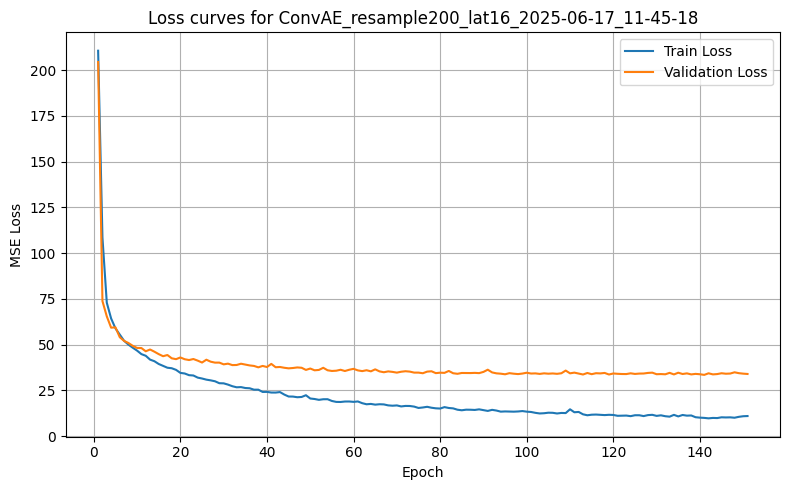

In [10]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    """
    Starting from the current file (if in a script) or cwd (if in a notebook),
    walk upward until you find a directory that contains `marker_dir`.
    """
    # start from __file__ if available (script), else from cwd()
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    # fallback to cwd
    return Path.cwd().resolve()

# 1) Locate project root by looking for the "artifacts" folder
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Build checkpoint path
ckpt_path = (
    PROJECT_ROOT
    / "artifacts"
    / "autoencoder"
    / "checkpoints"
    / "ConvAE_resample200_lat16_2025-06-17_11-45-18.pt"
)
if not ckpt_path.exists():
    raise FileNotFoundError(f"Checkpoint not found at: {ckpt_path}")

# 3) Load checkpoint
ckpt = torch.load(ckpt_path, map_location="cpu")

# --- extract losses from the nested 'history' dict ---
history    = ckpt.get("history", {})
train_loss = history.get("train_loss")
val_loss   = history.get("val_loss")

if train_loss is None or val_loss is None:
    raise KeyError(f"Couldn’t find 'train_loss'/'val_loss' in checkpoint history; keys are {list(history.keys())}")

# --- build epoch axis and plot ---
epochs = list(range(1, len(train_loss) + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, train_loss, label="Train Loss")
plt.plot(epochs, val_loss,   label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title(f"Loss curves for {ckpt.get('run_name','<unnamed run>')}")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



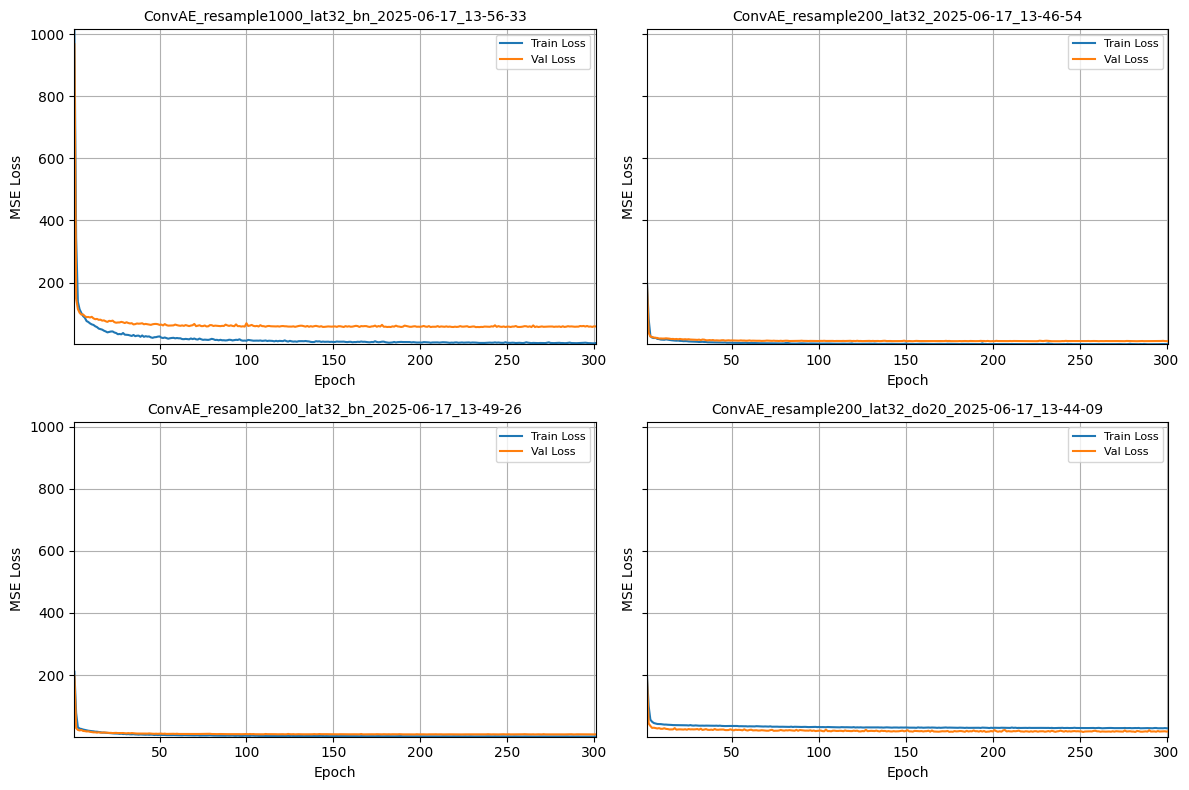

In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

# 1) Locate project root
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Define your run names (no “.pt” suffix here)
run_names = [
    "ConvAE_resample1000_lat32_bn_2025-06-17_13-56-33",
    "ConvAE_resample200_lat32_2025-06-17_13-46-54",
    "ConvAE_resample200_lat32_bn_2025-06-17_13-49-26",
    "ConvAE_resample200_lat32_do20_2025-06-17_13-44-09",
]

# 3) Load all histories
histories = {}
for name in run_names:
    ckpt_path = (
        PROJECT_ROOT
        / "artifacts"
        / "autoencoder"
        / "checkpoints"
        / f"{name}.pt"
    )
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location="cpu")
    h = ckpt.get("history", {})
    if "train_loss" not in h or "val_loss" not in h:
        raise KeyError(f"No losses in history for {name}")
    histories[name] = {
        "train": h["train_loss"],
        "val":   h["val_loss"]
    }

# 4) Compute global y-limits
all_vals = []
for h in histories.values():
    all_vals += h["train"] + h["val"]
ymin, ymax = min(all_vals), max(all_vals)

# 5) Plot in a 2×2 grid with shared y-axis scale
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for ax, (name, h) in zip(axes, histories.items()):
    epochs = list(range(1, len(h["train"]) + 1))
    ax.plot(epochs, h["train"], label="Train Loss")
    ax.plot(epochs, h["val"],   label="Val Loss")
    ax.set_title(name, fontsize=10)
    ax.set_xlim(1, max(len(h["train"]), len(h["val"])))
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


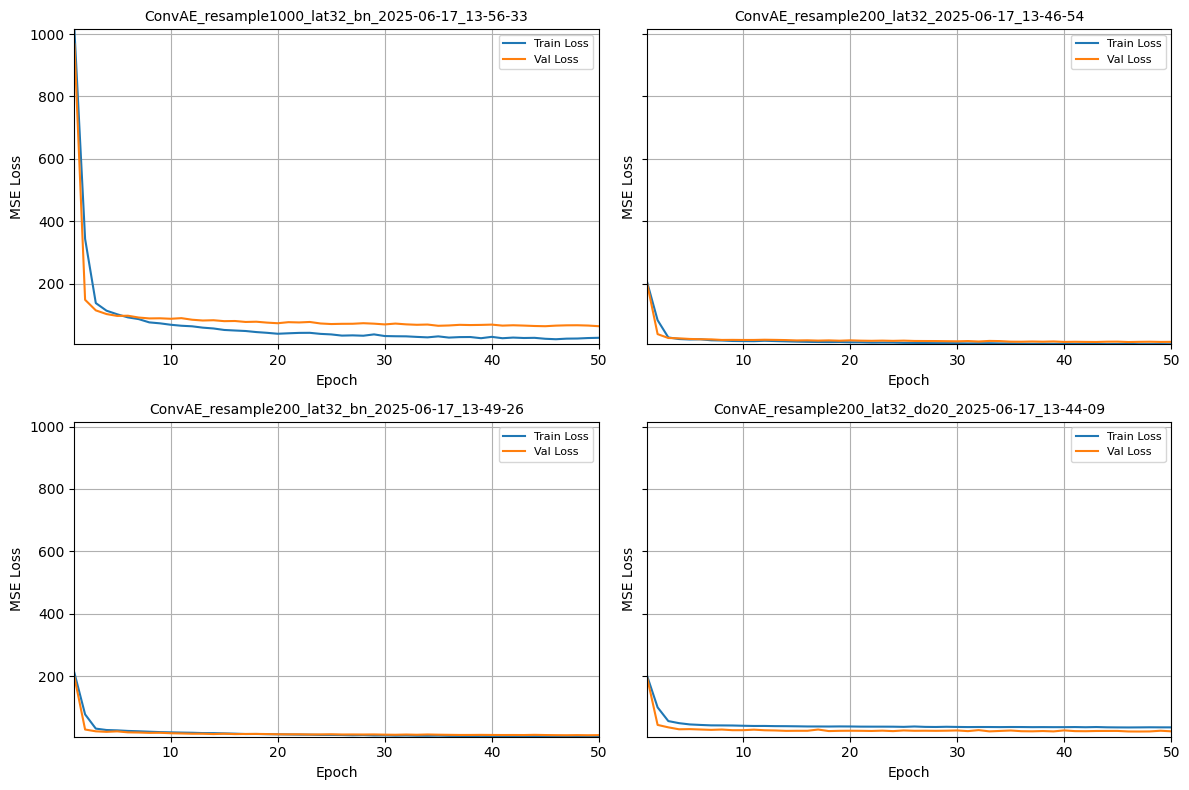

In [2]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

# 1) Locate project root
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Define your run names
run_names = [
    "ConvAE_resample1000_lat32_bn_2025-06-17_13-56-33",
    "ConvAE_resample200_lat32_2025-06-17_13-46-54",
    "ConvAE_resample200_lat32_bn_2025-06-17_13-49-26",
    "ConvAE_resample200_lat32_do20_2025-06-17_13-44-09",
]

# 3) Load histories (but only keep the first 50 epochs)
MAX_EPOCHS = 50
histories = {}
for name in run_names:
    ckpt_path = (
        PROJECT_ROOT
        / "artifacts"
        / "autoencoder"
        / "checkpoints"
        / f"{name}.pt"
    )
    if not ckpt_path.exists():
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    ckpt = torch.load(ckpt_path, map_location="cpu")
    h = ckpt.get("history", {})
    tr = h.get("train_loss", [])
    va = h.get("val_loss", [])
    if not tr or not va:
        raise KeyError(f"No losses in history for {name}")
    # truncate to first MAX_EPOCHS
    histories[name] = {
        "train": tr[:MAX_EPOCHS],
        "val":   va[:MAX_EPOCHS]
    }

# 4) Compute y-limits over the truncated data
all_vals = []
for h in histories.values():
    all_vals += h["train"] + h["val"]
ymin, ymax = min(all_vals), max(all_vals)

# 5) Plot in a 2×2 grid, shared y-axis, first 50 epochs only
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharey=True)
axes = axes.flatten()

for ax, (name, h) in zip(axes, histories.items()):
    epochs = list(range(1, len(h["train"]) + 1))
    ax.plot(epochs, h["train"], label="Train Loss")
    ax.plot(epochs, h["val"],   label="Val Loss")
    ax.set_title(name, fontsize=10)
    ax.set_xlim(1, MAX_EPOCHS)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel("MSE Loss")
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


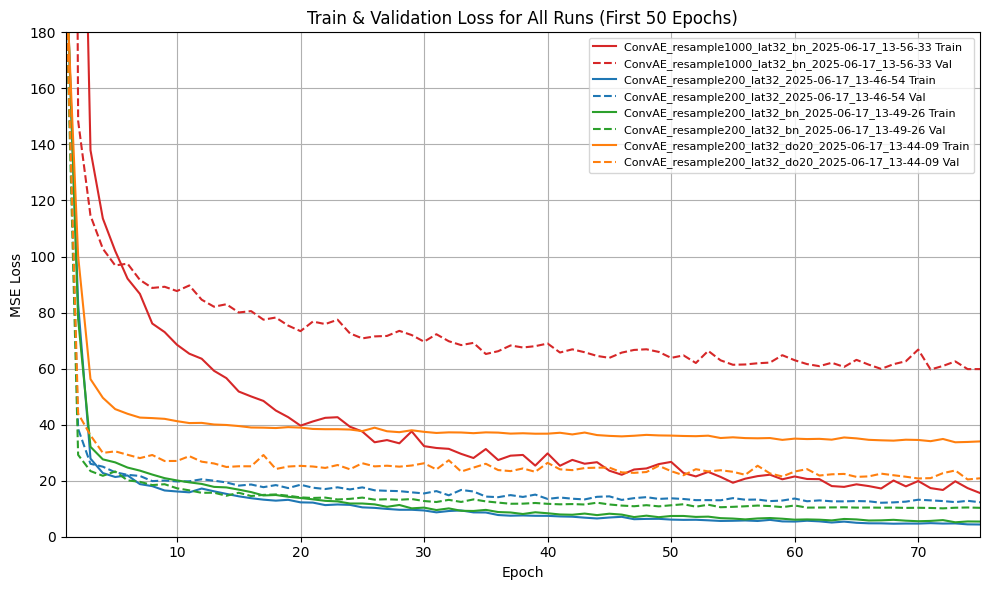

In [5]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

# 1) Locate project root
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Define runs and parameters
run_names = [
    "ConvAE_resample1000_lat32_bn_2025-06-17_13-56-33",
    "ConvAE_resample200_lat32_2025-06-17_13-46-54",
    "ConvAE_resample200_lat32_bn_2025-06-17_13-49-26",
    "ConvAE_resample200_lat32_do20_2025-06-17_13-44-09",
]
MAX_EPOCHS = 75

# 3) Load & truncate histories
histories = {}
for name in run_names:
    ckpt_path = (
        PROJECT_ROOT / "artifacts" / "autoencoder" / "checkpoints" / f"{name}.pt"
    )
    ckpt = torch.load(ckpt_path, map_location="cpu")
    h = ckpt["history"]
    histories[name] = {
        "train": h["train_loss"][:MAX_EPOCHS],
        "val":   h["val_loss"][:MAX_EPOCHS]
    }

# 4) Set up colors and linestyles
colors     = ["tab:red", "tab:blue", "tab:green", "tab:orange"]
linestyles = {"train": "-", "val": "--"}

# 5) Plot everything on one axes
fig, ax = plt.subplots(figsize=(10, 6))
for color, name in zip(colors, run_names):
    epochs = list(range(1, MAX_EPOCHS + 1))
    ax.plot(epochs, histories[name]["train"],
            color=color, linestyle=linestyles["train"],
            label=f"{name} Train")
    ax.plot(epochs, histories[name]["val"],
            color=color, linestyle=linestyles["val"],
            label=f"{name} Val")

ax.set_xlim(1, MAX_EPOCHS)
ax.set_ylim(0, 180)  # ← fixed y-axis from 0 to 180
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Train & Validation Loss for All Runs (First 50 Epochs)")
ax.grid(True)
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()



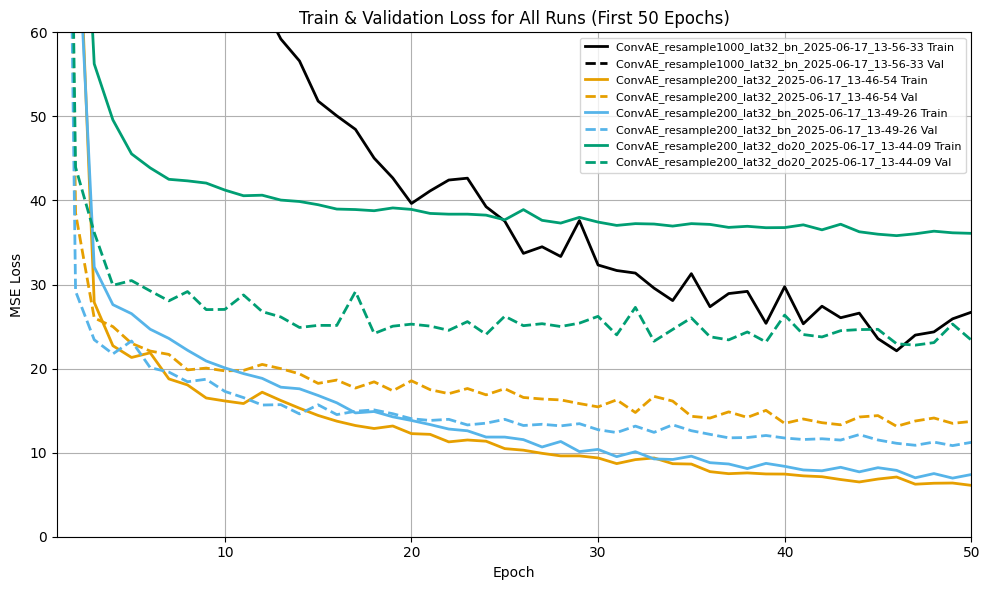

In [7]:
import torch
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve() if "__file__" in globals() else Path.cwd().resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

# 1) Locate project root
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Define runs and parameters
run_names = [
    "ConvAE_resample1000_lat32_bn_2025-06-17_13-56-33",
    "ConvAE_resample200_lat32_2025-06-17_13-46-54",
    "ConvAE_resample200_lat32_bn_2025-06-17_13-49-26",
    "ConvAE_resample200_lat32_do20_2025-06-17_13-44-09",
]
MAX_EPOCHS = 50

# 3) Load & truncate histories
histories = {}
for name in run_names:
    ckpt_path = (
        PROJECT_ROOT / "artifacts" / "autoencoder" / "checkpoints" / f"{name}.pt"
    )
    ckpt = torch.load(ckpt_path, map_location="cpu")
    h = ckpt["history"]
    histories[name] = {
        "train": h["train_loss"][:MAX_EPOCHS],
        "val":   h["val_loss"][:MAX_EPOCHS]
    }

# 4) Use colorblind-friendly palette (Okabe-Ito)
colors     = ["#000000", "#E69F00", "#56B4E9", "#009E73"]  # black, orange, sky blue, bluish green
linestyles = {"train": "-", "val": "--"}

# 5) Plot everything on one axes
fig, ax = plt.subplots(figsize=(10, 6))
for color, name in zip(colors, run_names):
    epochs = list(range(1, MAX_EPOCHS + 1))
    ax.plot(epochs, histories[name]["train"],
            color=color, linestyle=linestyles["train"], linewidth=2,
            label=f"{name} Train")
    ax.plot(epochs, histories[name]["val"],
            color=color, linestyle=linestyles["val"], linewidth=2,
            label=f"{name} Val")

ax.set_xlim(1, MAX_EPOCHS)
ax.set_ylim(0, 60)
ax.set_xlabel("Epoch")
ax.set_ylabel("MSE Loss")
ax.set_title("Train & Validation Loss for All Runs (First 50 Epochs)")
ax.grid(True)
ax.legend(loc="best", fontsize=8)
plt.tight_layout()
plt.show()


In [8]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
from pathlib import Path

def find_project_root(marker_dir: str = "artifacts") -> Path:
    start = Path(__file__).resolve()
    for parent in (start, *start.parents):
        if (parent / marker_dir).is_dir():
            return parent
    return Path.cwd().resolve()

# 1) Locate project root and add to path
PROJECT_ROOT = find_project_root("artifacts")
sys.path.insert(0, str(PROJECT_ROOT))

# 2) Import your model & dataset classes
from models.autoencoder.dataset_autoencoder import DatasetAutoencoder
from models.autoencoder.architectures.flexible_autoencoder import ConvAutoencoder

# 3) Specify the winning checkpoint
run_name  = "ConvAE_resample200_lat32_bn_2025-06-17_13-49-26"
ckpt_path = (PROJECT_ROOT / "artifacts" / "autoencoder" /
             "checkpoints" / f"{run_name}.pt")

# 4) Load checkpoint
ckpt = torch.load(ckpt_path, map_location="cpu")

# 5) Recreate the dataset (matching reduction parameters)
dataset = DatasetAutoencoder(
    path=PROJECT_ROOT / "data" / "waveforms",
    reduction="resample",
    n=200,
    save=False,
    force_reload=False
)

# 6) Instantiate the model with the same hyperparameters
model = ConvAutoencoder(
    dataset=dataset,
    latent_dim=32,
    dropout=0.0,
    use_batchnorm=True,
    batch_size=32,
    learning_rate=1e-3,
    train_frac=0.8,
    seed=None,
    reduction="resample",
    reduction_n=200
)

# 7) Load weights
if "model_state_dict" in ckpt:
    model.load_state_dict(ckpt["model_state_dict"])
elif "state_dict" in ckpt:
    model.load_state_dict(ckpt["state_dict"])
else:
    # if they saved the whole model object
    model = ckpt.get("model", model)

model.eval()

# 8) Build a synthetic waveform (sum of sinusoids + one cosine)
t = np.linspace(0, 1, 200)  # normalized time axis
y = np.zeros_like(t)
# three sinusoidal components
for amp, freq, phase in [(1.0,  1,   0.0),
                         (0.5,  3,   np.pi/4),
                         (0.2,  5,   np.pi/2)]:
    y += amp * np.sin(2*np.pi*freq*t + phase)
# plus one cosine component
y += 0.3 * np.cos(2*np.pi*2*t)

# 9) Prepare input tensor (B=1, C=1, L=200)
x = torch.from_numpy(y.astype(np.float32))[None, None, :]

# 10) Run through the autoencoder
with torch.no_grad():
    recon = model(x).cpu().numpy().squeeze()

# 11) Plot original vs. reconstruction
plt.figure(figsize=(10, 4))
plt.plot(t, y, label="Original Synthetic Wave", linewidth=2)
plt.plot(t, recon, linestyle="--", label="Reconstruction", linewidth=2)
plt.xlabel("Normalized Time")
plt.ylabel("Amplitude")
plt.title(f"Autoencoder Reconstruction on Synthetic Wave\n{run_name}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


NameError: name '__file__' is not defined